# Experimenting with orthogonality and different orthonormalizations (Under construction)

In [84]:
import numpy as np
import json
import random
import matplotlib.pyplot as plt
from pymatgen.io.cif import CifParser
from pymatgen.core.structure import Structure
from sklearn.linear_model import LinearRegression
from smol.cofe import ClusterSubspace, StructureWrangler, ClusterExpansion, RegressionData
from smol.moca import ClusterExpansionProcessor, CanonicalEnsemble
%matplotlib inline

# Open prim structure
with open('data/lno_prim.json', 'r') as f:
    lno_prim = Structure.from_dict(json.load(f))
    
# Open fitting data
with open('data/lno_fitting_data.json', 'r') as f:
    lno_data = [(Structure.from_dict(x['s']), x['toten']) for x in json.load(f)]

## Orthogonal vs Non-orthogonal basis
First lets look at how things can change when we use an orthogonal basis vs a non-orthogonal one.

In [76]:
# Create a cluster subspace with orthonormal basis functions
cs_or = ClusterSubspace.from_cutoffs(structure=lno_prim,
                                    cutoffs={2: 5, 3: 4.1},
                                    ltol=0.15, stol=0.2, angle_tol=5,
                                    supercell_size='O2-',
                                    basis='indicator',
                                    orthonormal=True)

# Now one with the standard non-orthogonal indicator basis
cs_nor = ClusterSubspace.from_cutoffs(structure=lno_prim,
                                    cutoffs={2: 5, 3: 4.1},
                                    ltol=0.15, stol=0.2, angle_tol=5,
                                    supercell_size='O2-',
                                    basis='indicator',
                                    orthonormal=False)


# Check if things are orthogonal
print(cs_or.basis_orthonormal, cs_nor.basis_orthonormal)

True False


In [77]:
# Put data in a structure Wranger for later

wrangler_or = StructureWrangler(cs_or)
for structure, tot_energy in lno_data:
    wrangler_or.add_data(structure,
                      properties={'total_energy': tot_energy})


wrangler_nor = StructureWrangler(cs_nor)
for structure, tot_energy in lno_data:
    wrangler_nor.add_data(structure,
                      properties={'total_energy': tot_energy})

/Users/zinabjadidi/Desktop/python3.8/smol/smol/cofe/wrangling/wrangler.py:731: UserWarning: Unable to match Ni4+6 O2-12 with properties {'total_energy': -188.28833} to supercell_structure. Throwing out.
 Error Message: Supercell could not be found from structure
  warnings.warn(
/Users/zinabjadidi/Desktop/python3.8/smol/smol/cofe/wrangling/wrangler.py:731: UserWarning: Unable to match Li+2 Ni4+4 Ni3+2 O2-12 with properties {'total_energy': -200.13866} to supercell_structure. Throwing out.
 Error Message: Supercell could not be found from structure
  warnings.warn(
/Users/zinabjadidi/Desktop/python3.8/smol/smol/cofe/wrangling/wrangler.py:731: UserWarning: Unable to match Li+2 Ni3+2 Ni4+4 O2-12 with properties {'total_energy': -200.42049} to supercell_structure. Throwing out.
 Error Message: Supercell could not be found from structure
  warnings.warn(
/Users/zinabjadidi/Desktop/python3.8/smol/smol/cofe/wrangling/wrangler.py:731: UserWarning: Unable to match Li+3 Ni4+4 Ni2+1 Ni3+1 O2-12 w

### Fit a CE with the two bases

In [85]:

from sklearn.linear_model import LinearRegression

# for orthonormal basis

estimator_or = LinearRegression(fit_intercept=False)
estimator_or.fit(wrangler_or.feature_matrix,
              wrangler_or.get_property_vector('total_energy'))

reg_data_or = RegressionData.from_sklearn(estimator_or,
                                       wrangler_or.feature_matrix,
                                       wrangler_or.get_property_vector('total_energy'))
expansion_or = ClusterExpansion(cs_or,
                             coefficients=estimator_or.coef_,
                             regression_data=reg_data_or)




# for non-orthogonal basisi

estimator_nor = LinearRegression(fit_intercept=False)
estimator_nor.fit(wrangler_nor.feature_matrix,
              wrangler_nor.get_property_vector('total_energy'))

reg_data_nor = RegressionData.from_sklearn(estimator_nor,
                                       wrangler_nor.feature_matrix,
                                       wrangler_nor.get_property_vector('total_energy'))
expansion_nor = ClusterExpansion(cs_nor,
                             coefficients=estimator_nor.coef_,regression_data=reg_data_nor)

In [91]:
from sklearn.metrics import mean_squared_error, max_error

train_predictions_or = np.dot(wrangler.feature_matrix,
                           expansion_or.coefs)
rmse = mean_squared_error(wrangler.get_property_vector('total_energy'),
                          train_predictions_or, squared=False)
maxer = max_error(wrangler.get_property_vector('total_energy'),
                  train_predictions_or)

print('"Details of the fit for orthonormal basis"')

print(f'RMSE (orthonormal) {rmse} eV/prim')
print(f'MAX (orthonormal) {maxer} eV/prim')
print(f'Fitted dielectric constant (orthonormal) {1/expansion_or.coefs[-1]}')






train_predictions_nor = np.dot(wrangler.feature_matrix,
                           expansion_nor.coefs)
rmse = mean_squared_error(wrangler.get_property_vector('total_energy'),
                          train_predictions_nor, squared=False)
maxer = max_error(wrangler.get_property_vector('total_energy'),
                  train_predictions_nor)

print('')
print('"Details of the fit for non-orthogonal basis"')
print(f'RMSE (non-orthogonal) {rmse} eV/prim')
print(f'MAX (non-orthogonal) {maxer} eV/prim')
print(f'Fitted dielectric constant (non-orthogonal) {1/expansion_nor.coefs[-1]}')


"Details of the fit for orthonormal basis"
RMSE (orthonormal) 0.009973122786564481 eV/prim
MAX (orthonormal) 0.019123139061427707 eV/prim
Fitted dielectric constant (orthonormal) 307.45128824464956

"Details of the fit for non-orthogonal basis"
RMSE (non-orthogonal) 3.2109800817144443 eV/prim
MAX (non-orthogonal) 5.393078871808438 eV/prim
Fitted dielectric constant (non-orthogonal) 38.4314110304181


### Look at differences between a correlation vectors
Notice that for the standard indicator correlations will always be positive, but for an orthonormalized basis this is not always the case.

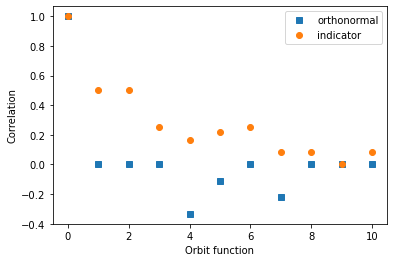

In [99]:
i = random.randint(0, len(wrangler_or.structures))
plt.plot(cs_or.corr_from_structure(wrangler_or.structures[i]), 's')

plt.plot(cs_nor.corr_from_structure(wrangler_nor.structures[i]), 'o')

plt.xlabel('Orbit function')
plt.ylabel('Correlation')
plt.legend(['orthonormal', 'indicator'])

### Compare canonical Monte Carlo runs with the different bases
Finally lets look at how MC runs differ for orthogonal vs non-orthogonal bases.

In [58]:
from pymatgen.transformations.standard_transformations import OrderDisorderedStructureTransformation

# Here we will just use the order disordered transformation from
# pymatgen to get an ordered version of a prim supercell.
# The structure will have the same composition set in the prim.
transformation = OrderDisorderedStructureTransformation()

supercell = expansion.cluster_subspace.structure.copy()
supercell.make_supercell(sc_matrix)

# this can take a bit of time....
test_struct = transformation.apply_transformation(supercell)
print(test_struct.composition)



Li+4 Ni3+4 Ni4+4 O2-16


In [63]:
from smol.moca import Sampler

# Create a supercell matrix
sc_matrix = np.array([[4, 0, 0],
                      [0, 2, 0],
                      [0, 0, 1]])



# this convenience method will take care of creating the appropriate
# processor for the given cluster expansion.
ensemble_or = CanonicalEnsemble.from_cluster_expansion(expansion_or,
                                                    sc_matrix)

ensemble_nor = CanonicalEnsemble.from_cluster_expansion(expansion_nor,
                                                    sc_matrix)

# Define initial occupancy

init_occu_or = ensemble_or.processor.occupancy_from_structure(test_struct)

init_occu_nor = ensemble_nor.processor.occupancy_from_structure(test_struct)



# This will take care of setting the defaults
# for the supplied canonical ensemble
sampler_or = Sampler.from_ensemble(ensemble_or,
                                temperature=2000)

sampler_nor = Sampler.from_ensemble(ensemble_nor,
                                temperature=2000)


sampler_or.run(1000000,
            initial_occupancies=init_occu_or,
            thin_by=200, # thin_by will save every 100th sample only
            progress=True) # progress will show progress bar



sampler_nor.run(1000000,
            initial_occupancies=init_occu_nor,
            thin_by=200, # thin_by will save every 100th sample only
            progress=True) # progress will show progress bar


Sampling 1 chain(s) from a cell with 32 sites...: 100%|█| 1000000/1000000 [01:06
Sampling 1 chain(s) from a cell with 32 sites...: 100%|█| 1000000/1000000 [01:13


In [100]:
# Samples are saved in a sample container
samples_or = sampler_or.samples

print('"Details of the MC run for orthonormal basis"')
print(f'Fraction of succesfull steps (efficiency) {sampler_or.efficiency()}')
print(f'The last step energy is {samples_or.get_energies()[-1]} eV')
print(f'The minimum energy in trajectory is {samples_or.get_minimum_energy()} eV')

# You can get the minimum energy structure and current structure
# by using the ensemble processor
curr_s_or = ensemble_or.processor.structure_from_occupancy(samples_or.get_occupancies()[-1])
min_s_or = ensemble_or.processor.structure_from_occupancy(samples_or.get_minimum_energy_occupancy())






samples_nor = sampler_nor.samples
print('')
print('"Details of the MC run for non orthogonal basis"')
print(f'Fraction of succesfull steps (efficiency)(non-orthogonal) {sampler_nor.efficiency()}')
print(f'The last step energy (for non-orthogonal) is {samples_nor.get_energies()[-1]} eV')
print(f'The minimum energy (for non-orthogonal) in trajectory is {samples_nor.get_minimum_energy()} eV')

# You can get the minimum energy structure and current structure
# by using the ensemble processor
curr_s_nor = ensemble_nor.processor.structure_from_occupancy(samples_nor.get_occupancies()[-1])
min_s_nor = ensemble_nor.processor.structure_from_occupancy(samples_nor.get_minimum_energy_occupancy())


"Details of the MC run for orthonormal basis"
Fraction of succesfull steps (efficiency) 0.002867
The last step energy is -276.10979940389507 eV
The minimum energy in trajectory is -276.563265112492 eV

"Details of the MC run for non orthogonal basis"
Fraction of succesfull steps (efficiency)(non-orthogonal) 0.004469
The last step energy (for non-orthogonal) is -287.67536067112815 eV
The minimum energy (for non-orthogonal) in trajectory is -287.9737407025881 eV


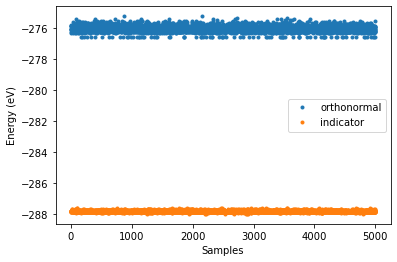

In [101]:
energies_or = samples_or.get_energies()
energies_nor = samples_nor.get_energies()

plt.plot(energies_or, '.')
plt.plot(energies_nor, '.')
plt.xlabel('Samples')
plt.ylabel('Energy (eV)')
plt.legend(['orthonormal', 'indicator'])

## Constructing a Cluster Subspace orthonormalized with respect to a concentration measure
This orthonormalized the basis functions with respect to the concentrations given in the prim structure. Note this does not give you a "concentration dependent" ECI's. Only ECI's centered about the given concentration.

In [53]:
# The prim is set to sites concentrations (Li+: 0.5, Vacancy: 0.5), (Ni+: 0.5, Ni: 40.5).
# You can see this from printing it.
# This is equivalent to a uniform concentration. So it is not different then standard orthonormalization.
print(lno_prim)
cs_onc = ClusterSubspace.from_cutoffs(structure=lno_prim,
                                    cutoffs={2: 5, 3: 4.1},
                                    ltol=0.15, stol=0.2, angle_tol=5,
                                    supercell_size='O2-',
                                    basis='sinusoid',
                                    orthonormal=True,
                                    use_concentration=True) # this will use the concentrations in the prim structure
                                                            # to create the "concentration-centered" basis

# Create another one without using concentration
cs_on = ClusterSubspace.from_cutoffs(structure=lno_prim,
                                    cutoffs={2: 5, 3: 4.1},
                                    ltol=0.15, stol=0.2, angle_tol=5,
                                    supercell_size='O2-',
                                    basis='sinusoid') # Note sinusoid is by construction already orthogonal.
# We can check orthogonality
print(cs_onc.basis_orthonormal, cs_on.basis_orthogonal)

Full Formula (Li0.5 Ni1 O2)
Reduced Formula: Li0.5Ni1O2
abc   :   2.969848   2.969848   5.143928
angles:  73.221350  73.221347  60.000002
Sites (4)
  #  SP                         a     b     c
---  ----------------------  ----  ----  ----
  0  Li+:0.500               0     0     0
  1  Ni3+:0.500, Ni4+:0.500  0.5   0.5   0.5
  2  O2-                     0.75  0.75  0.75
  3  O2-                     0.25  0.25  0.25
True True


In [55]:
wrangler_onc = StructureWrangler(cs_onc)
for structure, tot_energy in lno_data:
    wrangler_onc.add_data(structure,
                      properties={'total_energy': tot_energy})
    
    
wrangler_on = StructureWrangler(cs_on)
for structure, tot_energy in lno_data:
    wrangler_on.add_data(structure,
                      properties={'total_energy': tot_energy})

/Users/zinabjadidi/Desktop/python3.8/smol/smol/cofe/wrangling/wrangler.py:731: UserWarning: Unable to match Ni4+6 O2-12 with properties {'total_energy': -188.28833} to supercell_structure. Throwing out.
 Error Message: Supercell could not be found from structure
  warnings.warn(
/Users/zinabjadidi/Desktop/python3.8/smol/smol/cofe/wrangling/wrangler.py:731: UserWarning: Unable to match Li+2 Ni4+4 Ni3+2 O2-12 with properties {'total_energy': -200.13866} to supercell_structure. Throwing out.
 Error Message: Supercell could not be found from structure
  warnings.warn(
/Users/zinabjadidi/Desktop/python3.8/smol/smol/cofe/wrangling/wrangler.py:731: UserWarning: Unable to match Li+2 Ni3+2 Ni4+4 O2-12 with properties {'total_energy': -200.42049} to supercell_structure. Throwing out.
 Error Message: Supercell could not be found from structure
  warnings.warn(
/Users/zinabjadidi/Desktop/python3.8/smol/smol/cofe/wrangling/wrangler.py:731: UserWarning: Unable to match Li+3 Ni4+4 Ni2+1 Ni3+1 O2-12 w

In [57]:
print(cs_onc.corr_from_structure(wrangler_onc.structures[0]))
print(cs_on.corr_from_structure(wrangler_on.structures[0]))

[ 1.         -0.66666667 -0.66666667  0.44444444  0.55555556  0.55555556
  0.55555556 -0.44444444 -0.44444444 -0.66666667 -0.66666667]
[1.         0.66666667 0.66666667 0.44444444 0.55555556 0.55555556
 0.55555556 0.44444444 0.44444444 0.66666667 0.66666667]
